# Spark SQL

In [1]:
from common import Common
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf, struct
from pyspark.sql.types import Row
from pyspark.sql.functions import explode
from pyspark.sql.functions import col, asc

In [2]:
## Do not run this multiple times
common = Common()
sc,spark = common.get_spark_sql()

<SparkContext master=local appName=myapp>
2.4.5


In [3]:
spark.sql("show databases").show()
spark.sql("show tables in default").show()

+------------+
|databaseName|
+------------+
|     default|
+------------+

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
+--------+---------+-----------+



In [4]:
# file paths
csv_file = '/home/ec2-user/data/spotify.csv'
json_file = '/home/ec2-user/data/spotify.json'
gender_file = '/home/ec2-user/data/artist_gender.csv'

### Load CSV file to DF

In [5]:
df = spark.read.option("header", "true").option("mode", "DROPMALFORMED").csv(csv_file)
# df = spark.read.csv(csv_file, header=True, sep=",")
# df = spark.read.format("csv").option("header", "true").load(csv_file)

print ('columns: ', df.columns)
print ('count: ', df.count())
print ('\nschema: ')
df.printSchema()
df.show(5)

columns:  ['acousticness', 'danceability', 'duration_ms', 'energy', 'song_title', 'artist']
count:  2017

schema: 
root
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- song_title: string (nullable = true)
 |-- artist: string (nullable = true)

+------------+------------+-----------+------+--------------+----------------+
|acousticness|danceability|duration_ms|energy|    song_title|          artist|
+------------+------------+-----------+------+--------------+----------------+
|      0.0102|       0.833|     204600| 0.434|      Mask Off|          Future|
|       0.199|       0.743|     326933| 0.359|       Redbone|Childish Gambino|
|      0.0344|       0.838|     185707| 0.412|  Xanny Family|          Future|
|       0.604|       0.494|     199413| 0.338|Master Of None|     Beach House|
|        0.18|       0.678|     392893| 0.561|Parallel Lines|     Junior Boys

### Load JSON file to DF

In [6]:
df = spark.read.option("header", "true").option("mode", "DROPMALFORMED").json(json_file)

print ('columns: ', df.columns)
print ('count: ', df.count())
print ('\nschema: ')
df.printSchema()
df.show(5)

columns:  ['acousticness', 'artist', 'danceability', 'duration_ms', 'energy', 'song_title']
count:  2017

schema: 
root
 |-- acousticness: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- song_title: string (nullable = true)

+------------+----------------+------------+-----------+------+--------------+
|acousticness|          artist|danceability|duration_ms|energy|    song_title|
+------------+----------------+------------+-----------+------+--------------+
|      0.0102|          Future|       0.833|     204600| 0.434|      Mask Off|
|       0.199|Childish Gambino|       0.743|     326933| 0.359|       Redbone|
|      0.0344|          Future|       0.838|     185707| 0.412|  Xanny Family|
|       0.604|     Beach House|       0.494|     199413| 0.338|Master Of None|
|        0.18|     Junior Boys|       0.678|     392893| 0.561|Parallel Lines

### Convert RDD to DF

In [7]:
# read csv file as rdd
rdd = sc.textFile(csv_file)
header = rdd.first()
rdd = rdd.filter(lambda x : x != header).map(lambda x : x.split(","))
cols = header.split(",")
df = rdd.toDF(cols)

print ('columns: ', df.columns)
print ('\nschema: ')
df.printSchema()
df.show(5)

columns:  ['acousticness', 'danceability', 'duration_ms', 'energy', 'song_title', 'artist']

schema: 
root
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- song_title: string (nullable = true)
 |-- artist: string (nullable = true)

+------------+------------+-----------+------+--------------+----------------+
|acousticness|danceability|duration_ms|energy|    song_title|          artist|
+------------+------------+-----------+------+--------------+----------------+
|      0.0102|       0.833|     204600| 0.434|      Mask Off|          Future|
|       0.199|       0.743|     326933| 0.359|       Redbone|Childish Gambino|
|      0.0344|       0.838|     185707| 0.412|  Xanny Family|          Future|
|       0.604|       0.494|     199413| 0.338|Master Of None|     Beach House|
|        0.18|       0.678|     392893| 0.561|Parallel Lines|     Junior Boys|
+----------

### Load DF from Temporary View

In [8]:
df.createOrReplaceTempView("spotify")

# SQL statements can be run by using the sql methods provided by spark
df = spark.sql("SELECT * FROM spotify")
print ('columns: ', df.columns)
print ('\nschema: ')
df.printSchema()
df.show(5)

columns:  ['acousticness', 'danceability', 'duration_ms', 'energy', 'song_title', 'artist']

schema: 
root
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- song_title: string (nullable = true)
 |-- artist: string (nullable = true)

+------------+------------+-----------+------+--------------+----------------+
|acousticness|danceability|duration_ms|energy|    song_title|          artist|
+------------+------------+-----------+------+--------------+----------------+
|      0.0102|       0.833|     204600| 0.434|      Mask Off|          Future|
|       0.199|       0.743|     326933| 0.359|       Redbone|Childish Gambino|
|      0.0344|       0.838|     185707| 0.412|  Xanny Family|          Future|
|       0.604|       0.494|     199413| 0.338|Master Of None|     Beach House|
|        0.18|       0.678|     392893| 0.561|Parallel Lines|     Junior Boys|
+----------

In [9]:
print ("Before Delete")
spark.sql("show databases").show()
spark.sql("show tables in default").show()

spark.sql("DROP TABLE spotify")

print ("After Delete")
spark.sql("show databases").show()
spark.sql("show tables in default").show()

Before Delete
+------------+
|databaseName|
+------------+
|     default|
+------------+

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |  spotify|       true|
+--------+---------+-----------+

After Delete
+------------+
|databaseName|
+------------+
|     default|
+------------+

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
+--------+---------+-----------+



### Load DF using JDBC

In [10]:
print ('**** DO NOT RUN THIS BLOCK *****')

#### Include necessary jars
# ./bin/pyspark
#     --driver-class-path mysql-connector-java-5.1.36-bin.jar
#     --jars mysql-connector-java-5.1.36-bin.jar


# df = spark.read\
#     .format("jdbc")\
#     .option("url", "jdbc:mysql://localhost/database_name")\
#     .option("driver", "com.mysql.jdbc.Driver")\
#     .option("dbtable", "employees").option("user", "root")\
#     .option("password", "12345678").load()


**** DO NOT RUN THIS BLOCK *****


### Load DF from MongoDB

In [11]:
print ('**** DO NOT RUN THIS BLOCK *****')

#### Include necessary jars
# ./bin/pyspark
#     --driver-class-path mongo-spark-connector_2.11.jar
#     --jars mongo-spark-connector_2.11.jar


# df = spark.read.format("mongo").option("uri", "mongodb://127.0.0.1/people.contacts").load()


**** DO NOT RUN THIS BLOCK *****


### DF Operations

In [12]:
## Load the right CSV file in DF before starting DF Functions
print ('****** Load dataframe from a csv ******')
df = spark.read.option("header", "true").option("mode", "DROPMALFORMED").csv(csv_file)

print ('count: ', df.count())
df.show(3)

****** Load dataframe from a csv ******
count:  2017
+------------+------------+-----------+------+------------+----------------+
|acousticness|danceability|duration_ms|energy|  song_title|          artist|
+------------+------------+-----------+------+------------+----------------+
|      0.0102|       0.833|     204600| 0.434|    Mask Off|          Future|
|       0.199|       0.743|     326933| 0.359|     Redbone|Childish Gambino|
|      0.0344|       0.838|     185707| 0.412|Xanny Family|          Future|
+------------+------------+-----------+------+------------+----------------+
only showing top 3 rows



### Column datatypes

In [13]:
## datatypes of each column
print ('***** Column datatypes *****')
print ('Original datatypes: ', df.dtypes)

# change dtype of multiple columns
for column in df.columns:
    # add condition for the cols to be type cast
    if column not in ['song_title','artist']:
        df = df.withColumn(column, df[column].cast('double'))
print ('\nNew datatypes: ', df.dtypes)

# change dtype of one column
df = df.withColumn("acousticness", df["acousticness"].cast('string'))
print ('\nEnergy datatype: ', df.dtypes)

# change back
df = df.withColumn("acousticness", df["acousticness"].cast('double'))
print ('\nEnergy datatype back to double: ', df.dtypes)

print ('count: ', df.count())
df.show(3)

***** Column datatypes *****
Original datatypes:  [('acousticness', 'string'), ('danceability', 'string'), ('duration_ms', 'string'), ('energy', 'string'), ('song_title', 'string'), ('artist', 'string')]

New datatypes:  [('acousticness', 'double'), ('danceability', 'double'), ('duration_ms', 'double'), ('energy', 'double'), ('song_title', 'string'), ('artist', 'string')]

Energy datatype:  [('acousticness', 'string'), ('danceability', 'double'), ('duration_ms', 'double'), ('energy', 'double'), ('song_title', 'string'), ('artist', 'string')]

Energy datatype back to double:  [('acousticness', 'double'), ('danceability', 'double'), ('duration_ms', 'double'), ('energy', 'double'), ('song_title', 'string'), ('artist', 'string')]
count:  2017
+------------+------------+-----------+------+------------+----------------+
|acousticness|danceability|duration_ms|energy|  song_title|          artist|
+------------+------------+-----------+------+------------+----------------+
|      0.0102|      

### Select columns, Filter rows

In [14]:
print ('****** Select one column ******')
df1 = df.select("song_title")
print ('count: ', df1.count())
df1.show(3)

print ('****** Select multiple columns ******')
df1 = df.select(["song_title", "artist"])
print ('count: ', df1.count())
df1.show(3)

****** Select one column ******
count:  2017
+------------+
|  song_title|
+------------+
|    Mask Off|
|     Redbone|
|Xanny Family|
+------------+
only showing top 3 rows

****** Select multiple columns ******
count:  2017
+------------+----------------+
|  song_title|          artist|
+------------+----------------+
|    Mask Off|          Future|
|     Redbone|Childish Gambino|
|Xanny Family|          Future|
+------------+----------------+
only showing top 3 rows



In [15]:
print ('****** Filter rows by one column ******')
df1 = df.filter("energy > 0.9")
print ('count: ', df1.count())
df1.show(2)

print ('****** Filter rows by one column ******')
# Use filter() to return the rows that match a predicate
df2 = df.filter(df.energy > 0.9).sort(df.artist)
df2.show(2)

****** Filter rows by one column ******
count:  270
+------------+------------+-----------+------+-----------------+-----------+
|acousticness|danceability|duration_ms|energy|       song_title|     artist|
+------------+------------+-----------+------+-----------------+-----------+
|      0.0481|       0.603|   202853.0| 0.944|I've Seen Footage|Death Grips|
|      0.0239|       0.603|   270827.0| 0.955|  World In Motion|  New Order|
+------------+------------+-----------+------+-----------------+-----------+
only showing top 2 rows

****** Filter rows by one column ******
+------------+------------+-----------+------+--------------------+------+
|acousticness|danceability|duration_ms|energy|          song_title|artist|
+------------+------------+-----------+------+--------------------+------+
|      0.0028|       0.686|   211000.0| 0.915|Tearin' up My Hea...|*NSYNC|
|      0.0743|       0.754|   199787.0| 0.946|I Want You Back -...|*NSYNC|
+------------+------------+-----------+------+

In [16]:
print ('****** Filter rows by multiple columns OR operation ******')
df1 = df.filter((col("energy") > 0.9) | (col("duration_ms") > 470000)).sort(asc("artist"))
print ('count: ', df1.count())
df1.show(3)


print ('****** Filter rows by multiple columns AND operation ******')
df1 = df.filter((col("energy") > 0.9) & (col("duration_ms") > 470000)).sort(asc("artist"))
print ('count: ', df1.count())
df1.show(3)

****** Filter rows by multiple columns OR operation ******
count:  306
+------------+------------+-----------+------+--------------------+--------------------+
|acousticness|danceability|duration_ms|energy|          song_title|              artist|
+------------+------------+-----------+------+--------------------+--------------------+
|      0.0803|       0.664|   472013.0| 0.727|         Disco Devil|"Lee ""Scratch"" ...|
|      0.0743|       0.754|   199787.0| 0.946|I Want You Back -...|              *NSYNC|
|      0.0028|       0.686|   211000.0| 0.915|Tearin' up My Hea...|              *NSYNC|
+------------+------------+-----------+------+--------------------+--------------------+
only showing top 3 rows

****** Filter rows by multiple columns AND operation ******
count:  9
+------------+------------+-----------+------+--------------------+----------+
|acousticness|danceability|duration_ms|energy|          song_title|    artist|
+------------+------------+-----------+------+-------

In [17]:
# where() clause is equivalent to filter()
print ('****** Filter using Where clause ******')

df1 = df.where((col("energy") > 0.9) & (col("duration_ms") > 470000)).sort(asc("artist"))
print ('count: ', df1.count())
df1.show(3)


****** Filter using Where clause ******
count:  9
+------------+------------+-----------+------+--------------------+----------+
|acousticness|danceability|duration_ms|energy|          song_title|    artist|
+------------+------------+-----------+------+--------------------+----------+
|       0.183|       0.716|   576888.0| 0.957|Odofo Nyi Akyiri ...|Ebo Taylor|
|       0.107|       0.645|   591707.0| 0.924|Water No Get Enem...| Fela Kuti|
|       0.388|       0.704|   745653.0| 0.942|              Zombie| Fela Kuti|
+------------+------------+-----------+------+--------------------+----------+
only showing top 3 rows



In [18]:
print ('****** Filter using functions ******')

# filter using functions, pass one or more columns
@F.udf(returnType=BooleanType())
def filter_col(artist:str, dance:float):
    return (artist[0].lower() == 'a' or artist[0].lower() == 'b') and (dance >= 0.80)

df1 = df.filter(filter_col('artist', 'danceability'))
print ('count: ', df1.count())
df1.show(3)

****** Filter using functions ******
count:  29
+------------+------------+-----------+------+--------------------+------------+
|acousticness|danceability|duration_ms|energy|          song_title|      artist|
+------------+------------+-----------+------+--------------------+------------+
|       0.455|       0.847|   191541.0| 0.654|You Know You Like...| AlunaGeorge|
|       0.106|       0.912|   194040.0| 0.317|Who Is He (And Wh...|Bill Withers|
|      0.0567|       0.838|   194828.0| 0.537|     What I Might Do|  Ben Pearce|
+------------+------------+-----------+------+--------------------+------------+
only showing top 3 rows



In [19]:
# Handle missing data
print ('****** Handle missing data ******')

# Retrieve only rows with missing artist or song_title
df1 = df.filter(col("artist").isNotNull() & col("song_title").isNotNull())
print ('count: ', df1.count())
df1.show(3)

# Replace null values with -- using DataFrame Na function
df1 = df.fillna("--")
print ('count: ', df1.count())
df1.show(3)

****** Handle missing data ******
count:  2015
+------------+------------+-----------+------+------------+----------------+
|acousticness|danceability|duration_ms|energy|  song_title|          artist|
+------------+------------+-----------+------+------------+----------------+
|      0.0102|       0.833|   204600.0| 0.434|    Mask Off|          Future|
|       0.199|       0.743|   326933.0| 0.359|     Redbone|Childish Gambino|
|      0.0344|       0.838|   185707.0| 0.412|Xanny Family|          Future|
+------------+------------+-----------+------+------------+----------------+
only showing top 3 rows

count:  2017
+------------+------------+-----------+------+------------+----------------+
|acousticness|danceability|duration_ms|energy|  song_title|          artist|
+------------+------------+-----------+------+------------+----------------+
|      0.0102|       0.833|   204600.0| 0.434|    Mask Off|          Future|
|       0.199|       0.743|   326933.0| 0.359|     Redbone|Childish 

### Rename Columns

In [20]:
# Rename columns

print ('original columns: ', df.columns)
df.show(2)

## rename one or two columns
df1 = df.withColumnRenamed("acousticness", "acoustic")\
    .withColumnRenamed("danceability", "dance")
print ('Changed few columns: ', df1.columns)
df1.show(2)

## rename all columns
new_cols = ['acoustic', 'dance', 'duration', 'en', 'title', 'singer']
df1 = df.toDF(*new_cols)
print ('Changed all columns: ', df1.columns)
df1.show(2)

original columns:  ['acousticness', 'danceability', 'duration_ms', 'energy', 'song_title', 'artist']
+------------+------------+-----------+------+----------+----------------+
|acousticness|danceability|duration_ms|energy|song_title|          artist|
+------------+------------+-----------+------+----------+----------------+
|      0.0102|       0.833|   204600.0| 0.434|  Mask Off|          Future|
|       0.199|       0.743|   326933.0| 0.359|   Redbone|Childish Gambino|
+------------+------------+-----------+------+----------+----------------+
only showing top 2 rows

Changed few columns:  ['acoustic', 'dance', 'duration_ms', 'energy', 'song_title', 'artist']
+--------+-----+-----------+------+----------+----------------+
|acoustic|dance|duration_ms|energy|song_title|          artist|
+--------+-----+-----------+------+----------+----------------+
|  0.0102|0.833|   204600.0| 0.434|  Mask Off|          Future|
|   0.199|0.743|   326933.0| 0.359|   Redbone|Childish Gambino|
+--------+-

### Add/change columns

In [21]:
print ('Add/Change single column')

def acoustic_category(value):
    if value < 0.5:
        return 'low'
    return 'high'

udf_acoustic_category = udf(acoustic_category, StringType())
df1 = df.withColumn("acoustic_category", udf_acoustic_category("acousticness"))
print ('count: ', df1.count())
df1.show(3)

Add/Change single column
count:  2017
+------------+------------+-----------+------+------------+----------------+-----------------+
|acousticness|danceability|duration_ms|energy|  song_title|          artist|acoustic_category|
+------------+------------+-----------+------+------------+----------------+-----------------+
|      0.0102|       0.833|   204600.0| 0.434|    Mask Off|          Future|              low|
|       0.199|       0.743|   326933.0| 0.359|     Redbone|Childish Gambino|              low|
|      0.0344|       0.838|   185707.0| 0.412|Xanny Family|          Future|              low|
+------------+------------+-----------+------+------------+----------------+-----------------+
only showing top 3 rows



### Using StructType

In [22]:
print ('Using StructType')

schema = StructType([
    StructField("first_name", StringType(), False),
    StructField("last_name", StringType(), False)
])

def name_split(value):
    if len(value.split(" ")) >= 2:
        return (value.split(' ')[0], value.split(' ')[1])
    return (value, '')

udf_name_split = udf(name_split, schema)
df1 = df.select(udf_name_split("artist").alias("names"))
print ('count: ', df1.count())
df1.show(3)


Using StructType
count:  2017
+-------------------+
|              names|
+-------------------+
|         [Future, ]|
|[Childish, Gambino]|
|         [Future, ]|
+-------------------+
only showing top 3 rows



### drop columns

In [23]:
print ('***** Drop columns *****')

print ('drop single column')
df1 = df.drop('artist')
print ('count: ', df1.count())
df1.show(3)

print ('drop multiple columns')
df1 = df.drop('artist', 'song_title')
print ('count: ', df1.count())
df1.show(3)


***** Drop columns *****
drop single column
count:  2017
+------------+------------+-----------+------+------------+
|acousticness|danceability|duration_ms|energy|  song_title|
+------------+------------+-----------+------+------------+
|      0.0102|       0.833|   204600.0| 0.434|    Mask Off|
|       0.199|       0.743|   326933.0| 0.359|     Redbone|
|      0.0344|       0.838|   185707.0| 0.412|Xanny Family|
+------------+------------+-----------+------+------------+
only showing top 3 rows

drop multiple columns
count:  2017
+------------+------------+-----------+------+
|acousticness|danceability|duration_ms|energy|
+------------+------------+-----------+------+
|      0.0102|       0.833|   204600.0| 0.434|
|       0.199|       0.743|   326933.0| 0.359|
|      0.0344|       0.838|   185707.0| 0.412|
+------------+------------+-----------+------+
only showing top 3 rows



## drop duplicate rows

In [24]:
print ('***** Drop columns *****')

print ('drop duplicates from all columns')
df1 = df.dropDuplicates()
print ('count: ', df1.count())
df1.show(3)

print ('drop duplicates for a specific column')
df1 = df.dropDuplicates(['artist'])
print ('count: ', df1.count())
df1.show(3)

print ('drop duplicates for a pair of columns')
df1 = df.dropDuplicates(['artist', 'song_title'])
print ('count: ', df1.count())
df1.show(3)

***** Drop columns *****
drop duplicates from all columns
count:  2008
+------------+------------+-----------+------+--------------------+-----------+
|acousticness|danceability|duration_ms|energy|          song_title|     artist|
+------------+------------+-----------+------+--------------------+-----------+
|       0.212|       0.723|   322050.0| 0.687|Glyde 2nyte (feat...|   Dâm-Funk|
|      0.0487|       0.289|   273000.0| 0.523|Walk On By - Sing...|Isaac Hayes|
|      0.0267|       0.821|   632693.0| 0.793|Get Lucky - Daft ...|  Daft Punk|
+------------+------------+-----------+------+--------------------+-----------+
only showing top 3 rows

drop duplicates for a specific column
count:  1343
+------------+------------+-----------+------+---------------------------+---------+
|acousticness|danceability|duration_ms|energy|                 song_title|   artist|
+------------+------------+-----------+------+---------------------------+---------+
|      0.0198|       0.571|   199640.0

### Joins

In [25]:
print ('***** Read gender csv file *****')
gender_df = spark.read.csv(gender_file, header=True, sep=",")

print ('-- gender file')
print ('Original count: ', gender_df.count())
gender_df.show(2)

gender_df = gender_df.dropDuplicates()
print ('Unique count: ', gender_df.count())
gender_df.show(5)

print ('-- main file')
print ('count: ', df.count())
df.show(3)


***** Read gender csv file *****
-- gender file
Original count:  2017
+----------------+------+
|            name|gender|
+----------------+------+
|          Future|  male|
|Childish Gambino|  male|
+----------------+------+
only showing top 2 rows

Unique count:  1343
+--------------+------+
|          name|gender|
+--------------+------+
|  Mikal Cronin|female|
|     Badfinger|  male|
|Global Deejays|  male|
|    Adrian Lux|  male|
|   Mike Posner|female|
+--------------+------+
only showing top 5 rows

-- main file
count:  2017
+------------+------------+-----------+------+------------+----------------+
|acousticness|danceability|duration_ms|energy|  song_title|          artist|
+------------+------------+-----------+------+------------+----------------+
|      0.0102|       0.833|   204600.0| 0.434|    Mask Off|          Future|
|       0.199|       0.743|   326933.0| 0.359|     Redbone|Childish Gambino|
|      0.0344|       0.838|   185707.0| 0.412|Xanny Family|          Future|


In [26]:
print ('***** Inner join *****')
joined_df = df.join(gender_df, df.artist == gender_df.name, 'inner').drop(gender_df.name)

print ('-- joined df')
print ('count: ', joined_df.count())
joined_df.show(3)

***** Inner join *****
-- joined df
count:  2014
+------------+------------+-----------+------+------------+----------------+------+
|acousticness|danceability|duration_ms|energy|  song_title|          artist|gender|
+------------+------------+-----------+------+------------+----------------+------+
|      0.0102|       0.833|   204600.0| 0.434|    Mask Off|          Future|  male|
|       0.199|       0.743|   326933.0| 0.359|     Redbone|Childish Gambino|  male|
|      0.0344|       0.838|   185707.0| 0.412|Xanny Family|          Future|  male|
+------------+------------+-----------+------+------------+----------------+------+
only showing top 3 rows



### Summary Statistics

In [27]:
print ('***** Summary Statistics *****')

print ('stats of all columns - df')
df.describe().show()

print ('stats of a particular column')
df.describe('acousticness').show()

***** Summary Statistics *****
stats of all columns - df
+-------+-------------------+------------------+------------------+-------------------+----------------------------+----------------+
|summary|       acousticness|      danceability|       duration_ms|             energy|                  song_title|          artist|
+-------+-------------------+------------------+------------------+-------------------+----------------------------+----------------+
|  count|               2017|              2017|              2017|               2017|                        2015|            2017|
|   mean|0.18759003442241004|0.6184219137332657|246306.19732275658| 0.6815771442736742|                       851.5|            null|
| stddev|0.25998925978484005|0.1610289674217501|  81981.8142190362|0.21027300892392292|           915.1701116914459|            null|
|    min|            2.84E-6|             0.122|           16042.0|             0.0148|        "Beauty and the B...|             !!!|
|    

### Aggregation

In [28]:
print ('***** Aggregation: count *****')

df1 = df.groupBy("artist").count()
print ('count: ', df1.count())
df1.show(5)

***** Aggregation: count *****
count:  1343
+--------------+-----+
|        artist|count|
+--------------+-----+
|         Virgo|    1|
|        Grimes|    6|
|    Snoop Dogg|    2|
|The Black Keys|    1|
|     Clockwork|    1|
+--------------+-----+
only showing top 5 rows



In [29]:
print ('***** Aggregation: count and sort *****')

df1 = df.groupBy("artist").count().sort(col("count").desc())
print ('count: ', df1.count())
df1.show(5)

***** Aggregation: count and sort *****
count:  1343
+---------------+-----+
|         artist|count|
+---------------+-----+
|          Drake|   16|
|      Rick Ross|   13|
|     Disclosure|   12|
|  WALK THE MOON|   10|
|Backstreet Boys|   10|
+---------------+-----+
only showing top 5 rows



In [30]:
print ('***** Aggregation: average *****')

df1 = df.agg({"acousticness" : "sum"})
print ('count: ', df1.count())
df1.show()


***** Aggregation: average *****
count:  1
+------------------+
| sum(acousticness)|
+------------------+
|378.36909943000103|
+------------------+



### Save files

In [33]:
print ('**** DO NOT RUN THIS BLOCK *****')

# # This saves output in part files
# mydf.write.format('csv')
#     .option('header',True)
#     .mode('overwrite')
#     .option('sep',',')
#     .save('file://<file_path>')

# ## If you want to save output as regular files
# ##    convert dataframe to list and use regular python to write files

# rdd = mydf.rdd.map(tuple)
# list_to_write_to_file = list(rdd.collect())


**** DO NOT RUN THIS BLOCK *****


### Optional - Plots

***** An example using pandas and Matplotlib integration *****


<Figure size 432x288 with 0 Axes>

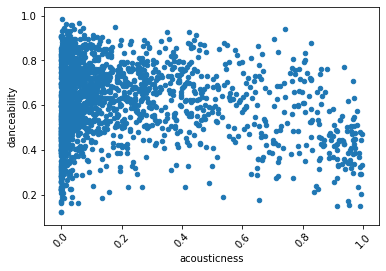

In [34]:
print ('***** An example using pandas and Matplotlib integration *****')

import pandas as pd
import matplotlib.pyplot as plt

plt.clf()
pdDF = df.toPandas()
pdDF.plot(x='acousticness', y='danceability', kind='scatter', rot=45)
display()
